# 1.Transformer :  XML -> CSV  de structure "texte, parti"

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd

In [2]:
def extract_data_brut(file_path,output_csv_path):
    '''
    extraire les textes et leurs parities à partir des corpus d'apprentissage bruts
    et les conserver dans un fichier csv pour chaque langue
    '''    
    tree = ET.parse(file_path)
    root = tree.getroot()
    data = []
    for doc in root.findall('.//doc'): 
        # obtenir tous les paragraphes du texte et les joindre en un seul
        text_elements = doc.findall('.//texte//p')
        texte = ' '.join([elem.text.strip() for elem in text_elements if elem.text])
        # obtenir les partis politiques
        partis = [parti.get('valeur') for parti in doc.findall('.//PARTI')]
        for parti in partis:
            data.append({'texte': texte, 'parti': parti})
    # créer un dataframe et l'enregistrer dans un fichier csv
    df = pd.DataFrame(data)
    return df.to_csv(output_csv_path, index=False, encoding='utf-8')

In [3]:
def extract_and_combine_text_label(xml_file_path, label_file_path, output_csv_path):
    '''
    extraire les textes tests dans les fichiers xml de et leurs labels des fichiers textes 
    et les combiner dans un seul fichier csv pour chaque langue
    '''   
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    test_data = []
    for doc in root.findall('.//doc'):
        # obtenir tous les paragraphes du texte et les joindre en un seul
        text_elements = doc.findall('.//texte//p')
        texte = ' '.join([elem.text.strip() for elem in text_elements if elem.text])
        test_data.append({'texte': texte})

    texte_df = pd.DataFrame(test_data)

    # lecture des labels à partir du fichier txt et les combiner avec les textes dans un même dataframe
    labels_df = pd.read_csv(label_file_path, sep='\t', header=None, names=['id', 'parti'])
    labels_df.set_index('id', inplace=True)
    
    # ajouter une colonne id pour pouvoir joindre les deux dataframes
    texte_df['id'] = range(1, len(texte_df) + 1)
    texte_df.set_index('id', inplace=True)
    # output est comme : [id, label]

    # joindre les deux dataframes en utilisant l'index id comme clé de jointure 
    combined_df = texte_df.join(labels_df, how='left')
    # output est comme : [id, texte, label]
    
    combined_df.to_csv(output_csv_path, index=False)

In [5]:
# extraire les apprentissages bruts
extract_data_brut(f'./corpus/deft09_appr/deft09_parlement_appr_fr.xml', f'./data/texte_brut/appr_brut_fr.csv')

In [6]:
# extraire les tests bruts
extract_and_combine_text_label(f'./corpus/deft09_test/deft09_parlement_test_fr.xml', f'./corpus/deft09_ref/deft09_parlement_ref_fr.txt', f'./data/texte_brut/test_brut_fr.csv')

**Jusqu'a maintenant, on a obtenu les textes et leur parti label pour chaque langue dans un fichier csv**

---

# 2. Pretraitement des textes

In [7]:
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


# installer les packages nltk nécessaires pour la préparation des données 
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xiaohua/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/xiaohua/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
def preprocess_text(text, lang):
    '''
    prétraiter le texte en appliquant les étapes suivantes:
    - convertir le texte en minuscules
    - supprimer les nombres
    - supprimer les apostrophes
    - supprimer les mots de longueur inférieure ou égale à 2
    - supprimer les stopwords et la ponctuation
    '''
    # assurer que le texte est de type str
    if not isinstance(text, str):
        return str(text)  # convertir en str

    # charger les stopwords selon la langue
    if lang == 'en':
        stop_words = set(stopwords.words('english'))
    elif lang == 'fr':
        stop_words = set(stopwords.words('french'))
    elif lang == 'it':
        stop_words = set(stopwords.words('italian'))

    # enlever les symboles ennuyeux et les nombres 
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r"['’‘]", ' ', text)  
    text = re.sub(r'\b\w{1,2}\b', '', text)
    
    
    
    words = word_tokenize(text.lower())

    # enlever les stopwords et la ponctuation
    words = [word for word in words if word not in stop_words and word not in string.punctuation]

    cleaned_text = ' '.join(words)
    return cleaned_text

In [9]:
def preprocess_csv(csv_path, lang,output_csv_path):
    '''
    lecture du fichier csv contenant les textes et leurs labels
    et prétraitement des textes
    '''
    # lire le fichier csv sauvegardé précédemment
    df = pd.read_csv(csv_path)

    # appliquer la fonction de prétraitement sur la colonne texte
    df['texte'] = df['texte'].apply(lambda x: preprocess_text(x, lang))

    df.to_csv(output_csv_path, index=False, encoding='utf-8')

**textes from csv -------> preprocess --------> preprocessed textes back to csv**

In [13]:
preprocess_csv(f'./data/texte_brut/appr_brut_fr.csv', 'fr', f'./data/texte_pretraite/appr_pretraite_fr.csv')

---

# 3. TF-IDF comme caractéristiques

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

In [79]:
def tfidfVectorize(CSV_train, CSV_test):
    '''
    vectoriser les textes en utilisant la méthode TF-IDF
    '''
    train_df = pd.read_csv(CSV_train)
    test_df = pd.read_csv(CSV_test)
    train_df.dropna(subset=['texte'], inplace=True)
    test_df.dropna(subset=['texte'], inplace=True)

    # initialiser le vectorizer avec les paramètres désirés
    vectorizer = TfidfVectorizer(
        ngram_range=(1,1),
        max_df=0.6,
        use_idf=True,
        sublinear_tf=True,
        max_features=50000
    )

    # vectoriser les textes d'entraînement et de test 
    print("Vectorizing train data...")
    X_train = vectorizer.fit_transform(tqdm(train_df['texte']))

    print("Vectorizing test data...")
    X_test = vectorizer.transform(tqdm(test_df['texte']))

    # récupérer les labels correspondants
    y_train = train_df['parti'].astype(str)
    y_test = test_df['parti'].astype(str)

    return X_train, X_test, y_train, y_test

# les etapes dessus sont pour vectoriser les textes en utilisant la méthode TF-IDF

In [80]:
# Obtenir tout d'abord les vecteurs et leur labels
X_train_fr, X_test_fr, y_train_fr, y_test_fr = tfidfVectorize('./data/texte_pretraite/appr_pretraite_fr.csv', './data/texte_pretraite/test_pretraite_fr.csv')

Vectorizing train data...


100%|██████████████████████████████████| 19365/19365 [00:01<00:00, 17342.46it/s]


Vectorizing test data...


100%|██████████████████████████████████| 12913/12913 [00:00<00:00, 16943.37it/s]


# 4. Modeling

In [ ]:
# modeling !
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [44]:
# on combine le modeling et l'évaluation

def evaluate(X_train, X_test, y_train, y_test, model):
    # Entraîner le modèle sur les données d'entraînement
    model.fit(X_train, y_train)
    
    # Prédire les labels sur les données de test
    y_pred = model.predict(X_test)

    return y_test, y_pred

In [109]:
# Ensuite : choisir, construire le modèle, et l'évaluer

# y_test_fr, y_pred_fr = evaluate(X_train_fr, X_test_fr, y_train_fr, y_test_fr, Perceptron()) # Perceptron
# y_test_fr, y_pred_fr = evaluate(X_train_fr, X_test_fr, y_train_fr, y_test_fr, LogisticRegression(max_iter=500)) # LogisticRegression
# y_test_fr, y_pred_fr = evaluate(X_train_fr, X_test_fr, y_train_fr, y_test_fr, sklearn.linear_model.SGDClassifier()) # SGDClassifier
y_test_fr, y_pred_fr = evaluate(X_train_fr, X_test_fr, y_train_fr, y_test_fr, MultinomialNB(alpha=0.001, fit_prior=True, class_prior=None)) # MultinomialNB
# y_test_fr, y_pred_fr = evaluate(X_train_fr, X_test_fr, y_train_fr, y_test_fr,RandomForestClassifier(n_estimators=100, max_depth=127, class_weight='balanced')) # RandomForestClassifier


**Normalement, après le modeling, nous pouvons accéder directement au 5ème étape, mais il faut parfois appliquer des techniques pour obtenir les meilleurs résultats pour un certain classifieur.**

> Ici, il s'agit des techniques comme : 
> 1. Suréchantillonnage(resample) pour les classes minoritaires comme ELDR et Verts-ALE.
> 2. Validation croisée K folds et Grid Searche pour fixer les paramètres

In [48]:
# SMOTE resample
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score

In [49]:
label_encoder = LabelEncoder()

# Cette fonction effectue un suréchantillonnage des données d'origine
# et fusionne print_scores pour afficher directement les résultats.
def evaluate_smote(X_train, X_test, y_train, y_test, model):
    y_train_encoded = label_encoder.fit_transform(y_train)
    
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)
    
    model.fit(X_train_resampled, y_train_resampled)
    
    y_pred_encoded = model.predict(X_test)
    
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    
    return print_scores(y_test, y_pred)

In [108]:
model = RandomForestClassifier(n_estimators = 200)
evaluate_smote(X_train_fr, X_test_fr, y_train_fr, y_test_fr, model)

Accuracy: 0.7698443429102455
Kappa Score: 0.6829489037114442
Classification Report:
               precision    recall  f1-score   support

        ELDR       0.96      0.63      0.76      1339
     GUE-NGL       0.89      0.78      0.83      1792
      PPE-DE       0.67      0.91      0.77      4571
         PSE       0.80      0.70      0.75      3626
   Verts-ALE       0.95      0.63      0.76      1585

    accuracy                           0.77     12913
   macro avg       0.85      0.73      0.77     12913
weighted avg       0.80      0.77      0.77     12913



---

In [40]:
# validation croisée K folds

# definir le model
model = RandomForestClassifier(n_estimators = 200)
k = 5
scores = cross_val_score(model, X_train_fr, y_train_fr, cv=k)

# output les precisions de chaque fold
print(f"precision scores pour chaque fold: {scores}")
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
print(f"Average precision: {scores.mean()}")

precision scores pour chaque fold: [0.40614511 0.41105086 0.40562871 0.40846889 0.4069197 ]
Average precision: 0.4076426542731733


In [106]:
logreg = RandomForestClassifier()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # 正则化强度的倒数
    'penalty': ['l1', 'l2'],  # 使用的正则化项
    'solver': ['liblinear', 'saga'],  # 优化算法
    'max_iter': [100, 500, 1000, 5000]  # 迭代次数
}

In [89]:
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_fr, y_train_fr)
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validated score: ", grid_search.best_score_)

# too long, computer too hot and fans ran so fast, I gave up.

Fitting 5 folds for each of 112 candidates, totalling 560 fits


/Users/xiaohua/opt/anaconda3/envs/macrun/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xiaohua/opt/anaconda3/envs/macrun/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xiaohua/opt/anaconda3/envs/macrun/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xiaohua/opt/anaconda3/envs/macrun/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xiaohua/opt/anaconda3/envs/macrun/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KeyboardInterrupt: 

---

# 5. Visualisation des scores et de matrix

In [26]:
for i in (y_test_fr):
    with open("y_test_fr.txt", "a") as f:
        f.write(str(i) + "\n")
for i in (y_pred_fr):
    with open("y_pred_fr.txt", "a") as f:
        f.write(str(i) + "\n")

In [27]:
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score

In [28]:
def print_scores(y_test, y_pred):
    '''
    Afficher les scores d'évaluation du modèle choisi
    '''
    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Kappa Score:", kappa)
    print("Classification Report:\n", report)

In [110]:
print_scores(y_test_fr, y_pred_fr)

Accuracy: 0.7088205684194223
Kappa Score: 0.5941860024173379
Classification Report:
               precision    recall  f1-score   support

        ELDR       0.95      0.49      0.64      1339
     GUE-NGL       0.90      0.62      0.73      1792
      PPE-DE       0.64      0.87      0.74      4571
         PSE       0.68      0.72      0.70      3626
   Verts-ALE       0.91      0.50      0.65      1585

    accuracy                           0.71     12913
   macro avg       0.81      0.64      0.69     12913
weighted avg       0.75      0.71      0.70     12913



In [33]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
def plot_confusion_matrix(y_test, y_pred, model):
    '''
    Sauvegarder la visualisation de la matrice de confusion du modèle choisi
    '''
    # obtenir les labels prédits par le modèle
    unique_labels = sorted(set(y_test) | set(y_pred))

    # générer la matrice de confusion en spécifiant les labels
    conf_matrix = confusion_matrix(y_test, y_pred, labels=unique_labels)

    # utiliser seaborn pour afficher la matrice de confusion sous forme de heatmap
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(conf_matrix, annot_kws={"size": 10}, annot=True, fmt='d', cmap='Greys', cbar=False,
                     xticklabels=unique_labels, yticklabels=unique_labels)

    # déplacer les étiquettes de l'axe x en haut
    ax.xaxis.set_label_position('top') 
    ax.xaxis.tick_top()

    plt.xlabel('Parti Prédit')
    plt.ylabel('Parti Réel')
    plt.title('Matrice de Confusion')

    # sauvegarder la figure dans le dossier result
    plt.savefig(f'./result/Confusion_Matrix_{model}.png', format='png', dpi=300)
    
    plt.show()


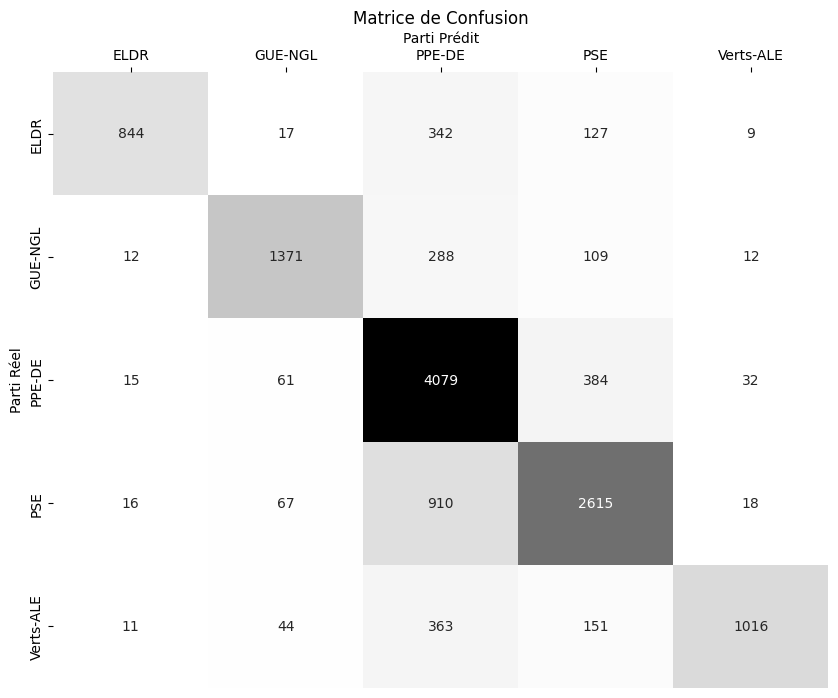

In [54]:
plot_confusion_matrix(y_test_fr, y_pred_fr, 'xxx')

---

In [ ]:
# learning curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.datasets import load_digits

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training exemples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="black")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="black",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="black",
             label="Validation-croisée Score")

    plt.legend(loc="best")
    return plt

In [ ]:

model = LogisticRegression(max_iter=500, penalty='l2', C=0.01)

plot_learning_curve(model, "", X_train_fr, y_train_fr, cv=5)

plt.show()